In [28]:
import os
import json
from collections import OrderedDict
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import aggregate_functions as agg
import plotting_functions as pf
import parse_facs_data as pfd
import statistical_tests as st

In [4]:
young_data_root = '~/Data/young_mouse_hscs'
young_lb_file = os.path.join(young_data_root, 'lineage_bias/lineage_bias_t0-0_from-counts.csv')
young_abundance = pd.read_csv(
    os.path.join(young_data_root, "M_all_Ania_percent-engraftment_filter 0.0001 070919_long.csv")
)
young_lineage_bias = pd.read_csv(young_lb_file)

old_data_root = '~/Data/stemcell_aging'
old_lb_file = os.path.join(old_data_root, 'lineage_bias/lineage_bias_t0-0_from-counts.csv')
old_abundance = pd.read_csv(
    os.path.join(old_data_root, "Ania_M_allAnia_percent-engraftment_052219_long.csv")
)
old_lineage_bias = pd.read_csv(old_lb_file)

In [15]:
young_donor_file = os.path.join(
    young_data_root,
    'young_donor.tsv'
)
young_gfp_file = os.path.join(
    young_data_root,
    'young_gfp.tsv'
)
young_wbc_file = os.path.join(
    young_data_root,
    'young_wbc.tsv'
)
young_wbc = pfd.parse_wbc_count_file(
    young_wbc_file
)


old_donor_file = os.path.join(
    old_data_root,
    'OT_2.0_donor_051818.txt'
)

old_gfp_file = os.path.join(
    old_data_root,
    'OT_2.0_GFP_051818.txt'
)

old_wbc_file = os.path.join(
    old_data_root,
    'OT_2.0_WBCs_051818-modified.txt'
)
old_wbc = pfd.parse_wbc_count_file(
    old_wbc_file
)

In [18]:
young_min_hsc_per_mouse = agg.calc_min_hsc_per_mouse(
    young_wbc_file,
    young_gfp_file,
    young_donor_file,
    tenx_hsc_counts_file='~/Data/tenx_hsc_counts.csv'
)
old_min_hsc_per_mouse = agg.calc_min_hsc_per_mouse(
    old_wbc_file,
    old_gfp_file,
    old_donor_file,
    tenx_hsc_counts_file='~/Data/tenx_hsc_counts.csv'
)

young_abundance = agg.filter_low_abund_hsc(
    young_min_hsc_per_mouse,
    young_abundance
)
old_abundance = agg.filter_low_abund_hsc(
    old_min_hsc_per_mouse,
    old_abundance
)

Length before filtering HSCs: 534
Length after filtering HSCs: 365
Length before filtering HSCs: 2303
Length after filtering HSCs: 327


In [23]:
b_min_abund = 0.05
myeloid_cell = 'gr'
lymphoid_cell = 'b'
timepoint_col = 'month'

young_lineage_bias = agg.filter_lineage_bias_cell_type_ratio_per_mouse(
    young_lineage_bias,
    timepoint_col,
    young_wbc,
    b_min_abund,
    myeloid_cell=myeloid_cell,
    lymphoid_cell=lymphoid_cell,
)
old_lineage_bias = agg.filter_lineage_bias_cell_type_ratio_per_mouse(
    old_lineage_bias,
    timepoint_col,
    old_wbc,
    b_min_abund,
    myeloid_cell=myeloid_cell,
    lymphoid_cell=lymphoid_cell,
)


 Filtering Lineage Bias Ratio Based on Gr/B Ratio Per Mouse at First Time Point
Length Before Filtering:  923
Length After Filtering:  312 


 Filtering Lineage Bias Ratio Based on Gr/B Ratio Per Mouse at First Time Point
Length Before Filtering:  8915
Length After Filtering:  3134 



In [24]:
young_hsc_data = young_abundance[young_abundance.cell_type == 'hsc']
old_hsc_data = old_abundance[old_abundance.cell_type == 'hsc']

last_young_clones = agg.find_last_clones(
    young_lineage_bias,
    'day'
)
labeled_young_last_clones = agg.add_bias_category(
    last_young_clones
)
bias_young_hsc_abundance_df = young_hsc_data.merge(
    labeled_young_last_clones[['code', 'mouse_id', 'bias_category_short']],
    how='inner',
    validate='1:1'
).assign(age='young')


last_old_clones = agg.find_last_clones(
    old_lineage_bias,
    'day'
)
labeled_old_last_clones = agg.add_bias_category(
    last_old_clones
)
bias_old_hsc_abundance_df = old_hsc_data.merge(
    labeled_old_last_clones[['code', 'mouse_id', 'bias_category_short']],
    how='inner',
    validate='1:1'
).assign(age='old')

hsc_bias_abundance = bias_old_hsc_abundance_df.append(bias_young_hsc_abundance_df)



Text(0.5, 1.0, 'HSC Abundance by Bias at Last Time Point')

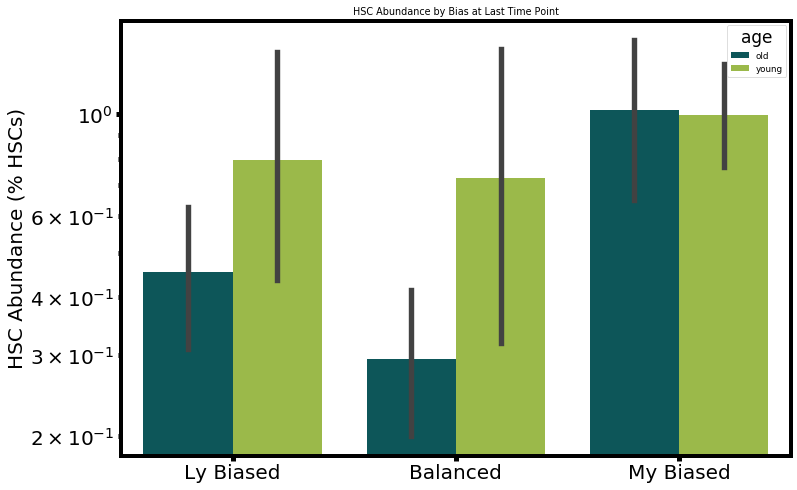

In [25]:
sns.set_context(
    'paper',
    rc={
        'lines.linewidth': 3,
        'axes.linewidth': 4,
        'axes.labelsize': 20,
        'xtick.major.width': 5,
        'ytick.major.width': 5,
        'ytick.minor.width': 5,
        'xtick.labelsize': 20,
        'ytick.labelsize': 20,
        'figure.titlesize': 'small',
        'axes.edgecolor': 'black',
        'xtick.color': 'black',
        'ytick.color': 'black',
        'figure.facecolor': 'white'
    }

    )
COLOR_PALETTES = json.load(open('lib/color_palettes.json', 'r'))
cats_order = [
    'Ly Biased',
    'Balanced',
    'My Biased',
]
unique_cats = list(OrderedDict.fromkeys(cats_order))


plt.figure(figsize=(12,8))
ax = sns.barplot(
    y='percent_engraftment',
    x='bias_category_short',
    order=unique_cats,
    data=hsc_bias_abundance,
    hue='age',
    palette=COLOR_PALETTES['age']
)
ax.set(yscale='log')
plt.xlabel('')
plt.ylabel('HSC Abundance (% HSCs)')
plt.title(
    'HSC Abundance by Bias at Last Time Point'
)

In [35]:
import importlib
importlib.reload(st)
st.ranksums_test_group_time(
    data=hsc_bias_abundance,
    test_col='percent_engraftment',
    timepoint_col='bias_category_short',
    overall_context='Old vs Young Mice',
    show_ns=True,
    group_col='age'
)


Performing Rank-Sum T-Test on Old vs Young Mice between age at each Bias Category Short
Bias_Category_Short Balanced P-Value: 0.08025133066595129 Mean: -0.43103823358430543
Bias_Category_Short Ly Biased P-Value: 0.0983015218322727 Mean: -0.3404442638914027
Bias_Category_Short My Biased P-Value: 0.0009506755510991031 Mean: 0.02515288502842794

Performing Rank Sum T-Test on Old vs Young Mice per age between Bias Category Shorts
Old Bias Category Short Balanced vs Ly Biased P-Value: 0.000528334717726902 Mean: -0.16002537025575453
Old Bias Category Short Balanced vs My Biased P-Value: 0.0022266203779211704 Mean: -0.7227634723571235
Old Bias Category Short Ly Biased vs My Biased P-Value: 0.3069365650948641 Mean: -0.562738102101369
Young Bias Category Short Balanced vs Ly Biased P-Value: 0.1424187254733281 Mean: -0.0694314005628518
Young Bias Category Short Balanced vs My Biased P-Value: 0.005186516173741671 Mean: -0.26657235374439014
Young Bias Category Short Ly Biased vs My Biased P-Value

In [ ]:
sems=[[],[]]
means=[]
colors=[]
for bias_cat in unique_cats:
    cats_df = myeloid_hsc_abundance_df[myeloid_hsc_abundance_df.bias_category == bias_cat]
    sems[0].append(0)
    sems[1].append(cats_df.percent_engraftment.sem())
    means.append(cats_df.percent_engraftment.mean())
    colors.append(COLOR_PALETTES['bias_category'][bias_cat])

coords = np.arange(len(unique_cats)) + 1
width = 0.4
fig, ax = plt.subplots(figsize=(12,8))
ax.bar(
    x=coords,
    height=means,
    width=width,
    tick_label=unique_cats,
    color=colors,
    log=True,
)
_, caps, _ = ax.errorbar(
    coords,
    means,
    yerr=sems,
    color='black',
    capsize=10,
    capthick=2,
    ls='none',
    )
caps[0].set_marker('_')
caps[0].set_markersize(0)

In [ ]:
save_format='png'
fname = '/home/sakre/Data/young_mouse_hscs/Graphs/' \
    + 'hsc_abundance_yvo' \
    + '.' + save_format

plt.savefig(
    fname,
    format=save_format,
    bbox_inches='tight',
)